In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import regex as re
import pprint

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import spacy
from textacy.extract import keyword_in_context

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from collections import defaultdict
from collections import Counter, ChainMap


plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [2]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

# Dataset preprocessing:

## Keep cases of Unknown Homeland (Ukendt hjemland):

In [3]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

(192, 1)

In [4]:

df.head()

,text
201,Nævnet stadfæstede i november 2021 Udl...
428,Nævnet stadfæstede i juni 2021 Udlændi...
464,Nævnet stadfæstede i juni 2021 Udlændi...
901,Nævnet stadfæstede i december 2020 Udl...
1291,Nævnet hjemviste i juni 2020 Udlænding...


Check for potential duplicates and drop them:

In [5]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,text
1333,Nævnet stadfæstede i maj 2020 Udlændin...
1352,Nævnet stadfæstede i maj 2020 Udlændin...
4000,Nævnet stadfæstede i januar 2018 Udlæn...
4001,Nævnet stadfæstede i januar 2018 Udlæn...
4055,Nævnet stadfæstede i januar 2018 Udlæn...
4058,Nævnet stadfæstede i januar 2018 Udlæn...


In [6]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(189, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [7]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,189.0,5008.539683,2046.292952,1104.0,3532.0,4753.0,6057.0,13105.0


## Boxplot:

<AxesSubplot:>

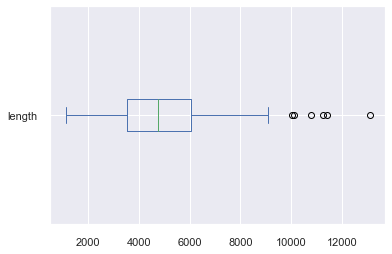

In [8]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

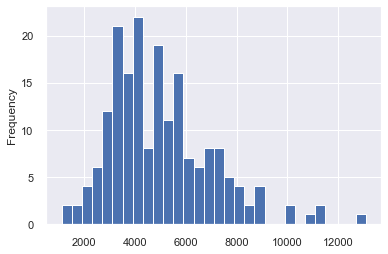

In [9]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Below are the steps taken to process the texts.

In [10]:
# Load danish model from spacy:
nlp = spacy.load("da_core_news_md")

STOPWORDS_DANISH = set(stopwords.words('danish'))

# domain specific words included:
domain_stopwords = {'nævnet', 'nævnets', 'nævnt', '​nævnet', 'flygtningenævnet', 'januar', 'februar', 'marts', 'april',
'maj', 'juni', 'juli', 'august', 'september', 'oktober', 'november', 'december', 'jf', 'ansøger'}

def import_additional_danish_stopwords(STOPWORDS_DANISH):
    additional_stopwords = open('misc/stopwords_dk.txt', 'r')
    for line in additional_stopwords:
        words = line.strip()
        STOPWORDS_DANISH.add(words)
    return STOPWORDS_DANISH


STOPWORDS_DANISH = import_additional_danish_stopwords(STOPWORDS_DANISH)
STOPWORDS_DANISH |= domain_stopwords 

PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'

In [11]:
# print(STOPWORDS_DANISH)

In [12]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


def remove_stopwords(text):
    """custom function to remove stopwords"""
    return [word for word in str(text).split() if word not in STOPWORDS_DANISH] 
    # [t for t in text if t not in STOPWORDS_DANISH]


# def tokenize(text):
#     """the following expression matches tokens consisting of at least one letter (\p{L}), 
#     preceded and followed by an arbitrary sequence of alphanumeric characters 
#     (\w includes digits, letters, and underscore) and hyphens (-)"""
#     return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def tokenize(text):
    doc = nlp.tokenizer(' '.join(text))
    return [token.text for token in doc]

def drop_single_letter_words(text):
    return [w for w in text if len(w) > 1]


def lemmatize(text):
    """custom function to lemmatize text"""
    doc = nlp(' '.join(text))
    # pos_tagged_text = text.pos
    return [token.lemma_ for token in doc]

# def remove_junk(text):
#     # Creating a spacy object
#     doc = nlp(' '.join(text))
#     # Checking if POS tag is X and printing them
#     for token in doc:
#         if token.pos_ == 'X':
#             print(token.text)
#     # Removing the tokens whose POS tag is junk.
#     clean_doc = [token.text for token in doc if not token.pos_ == 'X']

#     return clean_doc


Steps can be added or removed from the pipeline.

In [13]:
pipeline = [str.lower, remove_punctuation, remove_stopwords, drop_single_letter_words,
            tokenize, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [14]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [15]:
df.head()

,text,length,tokens,num_tokens
201,Nævnet stadfæstede i november 2021 Udl...,4753,"[stadfæste, 2021, udlændingestyrels, afgørelse...",333
428,Nævnet stadfæstede i juni 2021 Udlændi...,3149,"[stadfæste, 2021, udlændingestyrels, afgørelse...",225
464,Nævnet stadfæstede i juni 2021 Udlændi...,4433,"[stadfæste, 2021, udlændingestyrels, afgørelse...",324
901,Nævnet stadfæstede i december 2020 Udl...,2664,"[stadfæste, 2020, udlændingestyrels, afgørelse...",187
1291,Nævnet hjemviste i juni 2020 Udlænding...,4626,"[hjemvise, 2020, udlændingestyrels, afgørelse,...",330


# Analysis:

## Quantitative analysis:

## Decision extraction:

In [16]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

df_stad = df['tokens_joined'].str.contains('stadfæste', regex=True)
df_hem = df['tokens_joined'].str.contains('hjemvise', regex=True)
df_med = df['tokens_joined'].str.contains('meddele', regex=True)

# df['decision'] = np.where(df_stad & (df_hem | df_med), "check", np.nan)
df['decision'] = np.where((df_hem | df_med) & df_stad, "denied", np.where(
    df_hem | df_med, "granted", np.where(df_stad, "denied", np.nan)))


Plot decision:

Text(0, 0.5, 'outcomes')

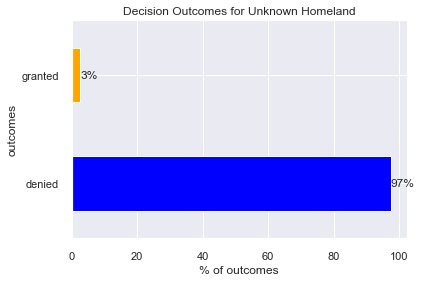

In [17]:
colors = ['blue', 'orange']

# Plot with normalized values:
ax = df['decision'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
ax.set_xlabel('% of outcomes')
ax.set_ylabel('outcomes')

# Uncomment to plot frequencies:
# ax = df['decision'].value_counts().plot(
#     kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')
# ax.bar_label(container)


## Year extraction:

In [18]:
df['year'] = df['tokens'].str[1]

Plot decision outcome rate by year:

Text(0, 0.5, 'no. of outcomes')

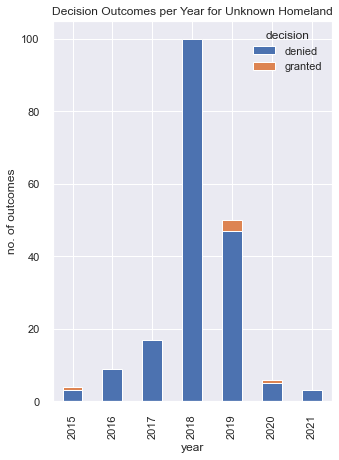

In [45]:
ax = df.groupby(['year'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Year for Unknown Homeland', stacked=True, figsize=(5, 7))
ax.set_xlabel('year')
ax.set_ylabel('no. of outcomes')

## Gender of applicants extraction:

In [20]:
male_pat = 'mandl.*?statsborg.*?|mand.*?ansøg.*?|mand.*?klag.*?'
female_pat = 'kvinde.*?statsborg.*?|kvinde.*?ansøg.*?|kvinde.*?klag.*?'

df_female = df['text'].str.contains(female_pat)
df_male = df['text'].str.contains(male_pat)

df['gender'] = np.where(df_male, "male", np.where(df_female, "female", "unidentified"))

Plot gender distribution:

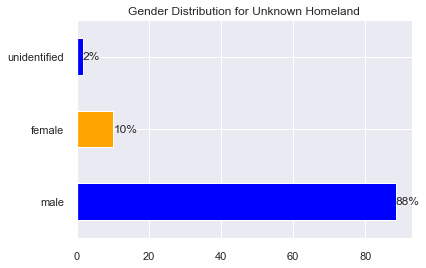

In [21]:
# Plot with normalized values:
ax = df['gender'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Gender Distribution for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')

Plot decision outcome rate by gender:

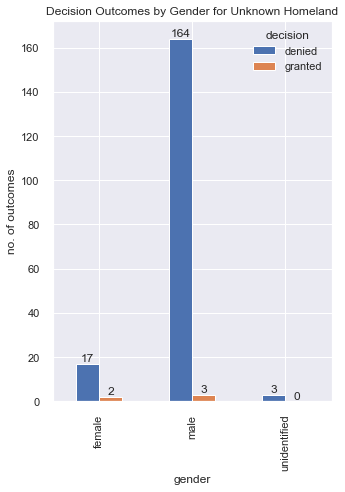

In [49]:
ax = df.groupby(['gender'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes by Gender for Unknown Homeland', figsize=(5, 7))
ax.set_xlabel('gender')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)

## Natural Language Processing:

## Frequency analysis:

Here we count the most frequent tokens in the **whole** corpus.


In [22]:
# Transform the counter into a Pandas DataFrame with the following function:

"""
The tokens make up the index of the DataFrame, while the frequency values are stored in a column named freq. 
The rows are sorted so that the most frequent words appear at the head.
The last parameter of count_words defines a minimum frequency of tokens to be included in the result. 
Its default is set to 2 to cut down on tokens occurring only once.
"""

def count_words(df, column='tokens', process=None, min_freq=2):
    # create counter and run through all data
    counter = Counter() 
    
    # process tokens and update counter
    def update(text):
        tokens = text if process is None else process(text, pipeline=pipeline)
        counter.update(tokens)
    
    df[column].map(update)
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq']) 
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [23]:
# See ten most frequent words in the whole corpus:
freq_df = count_words(df) 
freq_df.head(10)

# See all words with their frequencies:
# pd.value_counts(np.hstack(df['tokens']))

,freq
token,
ansøger,4307
Kuwait,1370
forklare,1237
oplyse,815
myndighed,795
mandlig,794
asylmotiv,748
forklaring,675
lægge,649


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

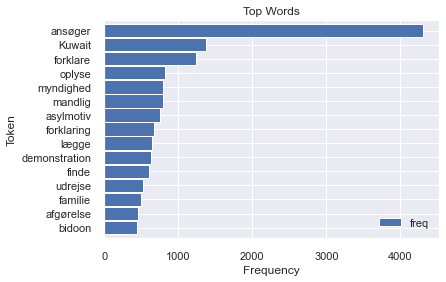

In [24]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95) 
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.

In [25]:
"""
The function iteratively collects the keyword contexts by applying the add_kwic function to each document with map. 
By default, the function returns a list of tuples of the form (left context, keyword, right context). 
If print_samples is greater than 0, a random sample of the results is printed. 
Sampling is especially useful with lots of documents because the first entries of the list 
would otherwise stem from a single or a very small number of documents.
"""

def kwic(doc_series, keyword, window=50, print_samples=5):
    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True, window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples == 0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f'{k} random samples out of {len(kwic_list)} ' +
              f"contexts for '{keyword}':")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', ' ', sample[0]) + ' ' +
                  sample[1]+' ' +
                  re.sub(r'[\n\t]', ' ', sample[2]))


Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.

In [26]:
kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 363 contexts for 'stk':
lladelse efter udlændingelovens § 7, stk. 1 eller  stk . 2, er opfyldt. Flygtningenævnet stadfæster derfo
o for overgreb omfattet af udlændin-gelovens § 7,  stk . 2. Flygtningenævnet stadfæster derfor Udlændinge
lgelse eller overgreb efter udlændingelovens § 7,  stk . 1, eller stk. 2, stadfæster Flygtningenævnet på 
vens § 7, stk. 1, eller overgreb omfattet af § 7,  stk . 2. Flygtningenævnet stadfæster derfor Udlændinge
ren opholdstilladelse efter udlændingelovens § 7,  stk . 1. Det fremgår af den oprindelige sag, at klager
ko for overgreb omfattet af udlændingelovens § 7,  stk . 2. Flygtningenævnet stadfæster derfor Udlændinge
e i medfør af udlændingelovens § 7, stk. 1, eller  stk . 2, er derfor ikke opfyldt. Flygtningenævnet stad
nde forfølgelse omfattet af udlændingelovens § 7,  stk . 1, eller overgreb omfattet af udlændingelovens §
 eller overgreb omfattet af udlændingelovens § 7,  stk . 1 eller 2. Flygtningenævnet stadfæster derfor 

KWIC for `opholdstilladelse`.

In [27]:
kwic(df['text'], 'opholdstilladelse', print_samples=10)

10 random samples out of 228 contexts for 'opholdstilladelse':
plysninger om sin identitet og således har opnået  opholdstilladelse  ved svig. Betingelserne for at inddrage klagerens
åbt sig, ikke kunne føre til, at hun blev meddelt  opholdstilladelse  efter udlændingelovens § 7. Det kan således i hve
ne ikke har sandsynliggjort, at betingelserne for  opholdstilladelse  efter udlændingelovens § 7, stk. 1 eller stk. 2, 
§ 7. Det følger heraf, at en udlænding, der søger  opholdstilladelse  efter udlændingelovens § 7 må sandsynliggøre den 
inger, som er nødvendige til bedømmelse af, om en  opholdstilladelse  i henhold til loven kan gives. I forhold til iden
r endvidere fremlagt bl.a. ansøgerens sudanesiske  opholdstilladelse , hvoraf fremgår, at ansøgeren er eritreisk statsb
statsløs) fra Kuwait kan ikke i sig selv begrunde  opholdstilladelse , idet ansøgeren har forklaret, at hans familie ha
r sig i Danmark. [F’s] ægtefælle, [B], fik i 2015  opholdstilladelse  i Danmark. Det lægges derfo

## N-gram analysis:

**N-grams** are neighboring sequences of items (words, letters, symbols) in a document. 

Most of the times a probability is assigned to the occurrence of a N-gram (or a word occurring next in a sequence of words). This can help decide which N-grams can be chunked together to form single entities or make predictions for next words (other possible use cases include spelling corrections).  

[Here](https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf), are some slides from Stanford which provide an introduction to N-gram models and the math that goes with it. 

In [28]:
def generate_N_grams(text, ngram=1):
    """"custom function to generate n-grams"""
    words = [word for word in text.split(
        " ") if word not in set(STOPWORDS_DANISH)]
    # print("Sentence after removing stopwords:", words)
    # Use the zip function to help us generate n-grams
    temp = zip(*[words[i:] for i in range(0, ngram)])
    # Concatentate the tokens into ngrams and return
    ans = [' '.join(ngram) for ngram in temp]
    return ans

In [29]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

In [30]:
values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['tokens_joined']:
    for word in generate_N_grams(text, 2):
        values[word] += 1

In [31]:
# Focus on more frequently occuring words.
# Sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Ten first values of the first column:
c1 = df_processed[0][:10]
# Ten first values of the second column:
c2 = df_processed[1][:10]


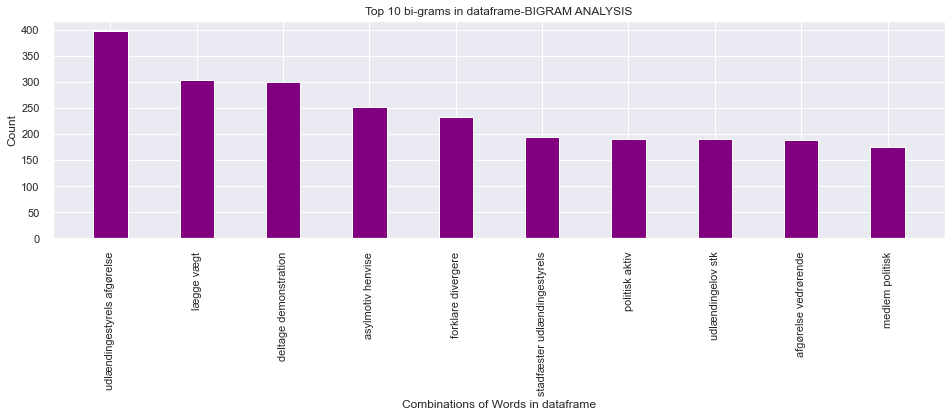

In [32]:
plt.figure(1, figsize=(16, 4))
plt.bar(c1, c2, color='purple',
        width=0.4)
plt.xlabel("Combinations of Words in dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 bi-grams in dataframe-BIGRAM ANALYSIS")
# plt.savefig("dataset-bigram.png")
plt.show()


## TF-IDF

**Term Frequency (TF):**

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

A value close to 1 indicates this term is very important to the document — and primarily composed of it. A low value could mean this term is not very important.

**Inverse Data Frequency (IDF):**

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

A value close to 0 indicates the term is very common — and not very helpful in differentiating this document from another. A higher value indicates the term is not very common and could be crucial to understanding the theme of this document.

The **TF-IDF** is the multiplication of TF by IDF.

A value close to 0 indicates the term is not important either in the corpus or the document or both. A larger value indicates the term is unique for the document or the corpus or both. This value works best in relation to other terms in the same document, and other documents.

In [33]:
# Get the column of interest:
docs = df['tokens_joined'].tolist()

# Create a vocabulary of words,eliminate stop words if any:

cv = CountVectorizer()
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(189, 4309)

In [34]:
word_count_vector = cv.fit_transform(docs)

# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['stadfæste',
 '2021',
 'udlændingestyrels',
 'afgørelse',
 'vedrørende',
 'mandlig',
 'statsborger',
 'ukendt',
 'hjemland',
 'indrejst']

In [35]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)


# Peek at the IDF values:
tfidf_transformer.idf_

array([5.55387689, 5.55387689, 3.11152986, ..., 4.63758616, 5.55387689,
       3.35665231])

In [36]:
# Sorts the values in the vector while preserving the column index
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    # Use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]

        # Keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(fname)

    # Create a tuples of feature,score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


In [37]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 192 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())   # tocoo() Return a COOrdinate representation of this matrix.

    # extract only the top n; n here is 10
    keywords = extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF


,doc,keywords
0,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'myanmar': 0.392, 'rohingya': 0.293, 'ansøger..."
1,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'ansøger': 0.417, 'algerium': 0.387, 'frankri..."
2,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'ansøger': 0.378, 'sudan': 0.285, '2020': 0.2..."
3,stadfæste 2020 udlændingestyrels afgørelse ved...,"{'somalia': 0.433, 'alshabaab': 0.417, 'kenya'..."
4,hjemvise 2020 udlændingestyrels afgørelse vedr...,"{'eritreisk': 0.4, 'eritrea': 0.35, 'etiopisk'..."
...,...,...
184,stadfæste 2016 udlændingestyrels afgørelse ved...,"{'fader': 0.499, 'liyu': 0.343, 'police': 0.29..."
185,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'onlf': 0.43, 'ansøger': 0.318, 'police': 0.3..."
186,hjemvise 2015 udlændingestyrels afgørelse vedr...,"{'etiopien': 0.196, 'hjemvise': 0.187, 'foreta..."
187,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'soldat': 0.531, 'ansøger': 0.218, 'burmesisk..."


In [38]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

# Add pretty printer:
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(most_common)


[   ('klager', 0.81),
    ('officer', 0.622),
    ('taliban', 0.569),
    ('soldat', 0.531),
    ('libyen', 0.508),
    ('police', 0.492),
    ('liyu', 0.492),
    ('tjetjenie', 0.465),
    ('georgien', 0.465),
    ('senegal', 0.464),
    ('sierra', 0.462),
    ('leone', 0.462),
    ('ægtefælle', 0.462),
    ('avis', 0.453),
    ('libysk', 0.443),
    ('hær', 0.436),
    ('holland', 0.436),
    ('somalia', 0.433),
    ('ghanesisk', 0.43),
    ('bøde', 0.426)]


Plot the pairs:

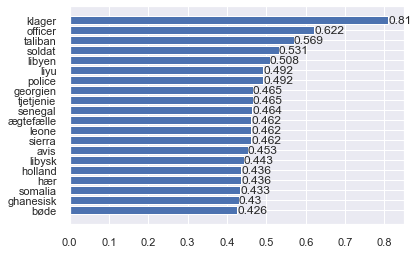

In [39]:
# plt.bar(range(len(most_common)), [val[1] for val in most_common], align='center')
# plt.xticks(range(len(most_common)), [val[0] for val in most_common])
# plt.xticks(rotation=70)

# sort values in tuple:
sorted_most_common = sorted(most_common, key=lambda x: x[1])

fig, ax = plt.subplots()
bars = ax.barh([val[0] for val in sorted_most_common], [val[1] for val in sorted_most_common])

ax.bar_label(bars)
plt.show()